In [ ]:
!pip install pyro-ppl

In [7]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import torch
import time
import torch
import torch.nn as nn
import torch.optim as optim



In [8]:
# Set the number of time steps
n_steps = 100
# Set the number of random walks
n_walks = 100

# Generate random walks with the same mean and variance
np.random.seed(123)
cov_matrix = np.diag(np.zeros(n_walks) + 1)
cov_matrix[cov_matrix==0] = 0.6
random_walks = np.random.multivariate_normal(np.zeros(n_walks), cov_matrix, size=n_steps)
random_walks = np.cumsum(random_walks, axis=0)




In [9]:
cov_matrix

array([[1. , 0.6, 0.6, ..., 0.6, 0.6, 0.6],
       [0.6, 1. , 0.6, ..., 0.6, 0.6, 0.6],
       [0.6, 0.6, 1. , ..., 0.6, 0.6, 0.6],
       ...,
       [0.6, 0.6, 0.6, ..., 1. , 0.6, 0.6],
       [0.6, 0.6, 0.6, ..., 0.6, 1. , 0.6],
       [0.6, 0.6, 0.6, ..., 0.6, 0.6, 1. ]])

In [10]:
intercepts = np.random.normal(0, 5, n_walks)
random_walks += np.tile(intercepts, (n_steps, 1))

# Create a data frame in wide format
wide_df = pd.DataFrame(random_walks, columns=[f'x{i}' for i in range(1, n_walks + 1)])

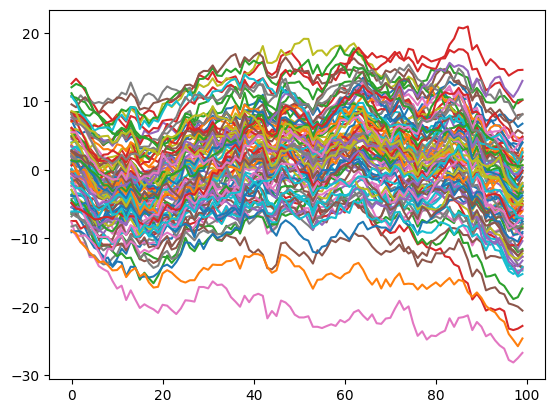

In [11]:
plt.plot(wide_df)

In [13]:
wide_df['t'] = range(1, n_steps + 1)

In [14]:

# Convert the wide-format DataFrame to long format
long_df = wide_df.melt(id_vars='t', var_name='level', value_name='value')


In [15]:
n_knots = 10

# Generate equally spaced knots
knots = np.linspace(min(long_df['t']), max(long_df['t']), num=n_knots)

# Define the piecewise linear function
def piecewise_linear(x, k):
    y = x - k
    y[x < 0] = 0
    y[x < k] = 0
    return y

# Define a function to create a linear spline basis
def create_basis(x, k):
    num_x = len(x)
    num_k = len(k)
    b = np.zeros((num_x, num_k))
    for i in range(num_k):
        b_i = piecewise_linear(x, k[i])
        b[:, i] = b_i
    return pd.DataFrame(b, columns=[f'basis_X{i+1}' for i in range(num_k)])



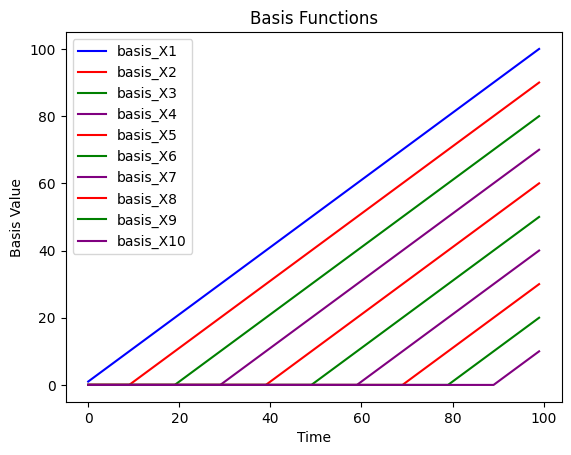

In [16]:
# Example usage
x = np.arange(1, n_steps + 1)  # Sample x values
k_values = np.arange(0, n_knots) * (n_steps / n_knots)  # Values of k
basis_matrix_wide = create_basis(x, k_values)

# Normalize the basis matrix
basis_matrix_wide.columns = [f'basis_X{i+1}' for i in range(n_knots)]

# Plot the basis functions
for i in range(n_knots):
    plt.plot(basis_matrix_wide[f'basis_X{i+1}'], label=f'basis_X{i+1}')

# Set line colors
colors = ['blue', 'red', 'green', 'purple', 'red', 'green', 'purple', 'red', 'green', 'purple']

for i, line in enumerate(plt.gca().get_lines()):
    line.set_color(colors[i])

plt.xlabel('Time')
plt.ylabel('Basis Value')
plt.title('Basis Functions')
plt.legend()
plt.show()

In [17]:
t = np.arange(1, n_steps + 1)
basis_matrix_wide.insert(0, 't', t)
basis_matrix_wide = pd.DataFrame(basis_matrix_wide)

# Merge the dataframes
long_df = long_df.merge(basis_matrix_wide, on='t', how='left')

In [18]:
# Identify rows to drop
drop = long_df[long_df['level'] == 'x10'].index
indices_to_remove = [905, 925, 963, 964, 991]

# Remove specified rows
filtered_indices = [i for i in drop if i not in indices_to_remove]

sample_df = long_df.drop(filtered_indices)



In [19]:
basis_vars = sample_df.columns.values[3:]

In [20]:
target = sample_df['value']

In [21]:
sample_df

t level      value  basis_X1  basis_X2  basis_X3  basis_X4  basis_X5  \
0       1    x1  -4.733509       1.0       0.0       0.0       0.0       0.0   
1       2    x1  -6.477154       2.0       0.0       0.0       0.0       0.0   
2       3    x1  -7.400127       3.0       0.0       0.0       0.0       0.0   
3       4    x1  -8.516379       4.0       0.0       0.0       0.0       0.0   
4       5    x1 -10.042101       5.0       0.0       0.0       0.0       0.0   
...   ...   ...        ...       ...       ...       ...       ...       ...   
9995   96  x100  -4.028363      96.0      86.0      76.0      66.0      56.0   
9996   97  x100  -5.222063      97.0      87.0      77.0      67.0      57.0   
9997   98  x100  -5.832636      98.0      88.0      78.0      68.0      58.0   
9998   99  x100  -6.944036      99.0      89.0      79.0      69.0      59.0   
9999  100  x100  -7.101347     100.0      90.0      80.0      70.0      60.0   

      basis_X6  basis_X7  basis_X8  basis_X9  basis_X10  
0          0.0       0.0       0.0       0.0        0.0  
1          0.0       0.0       0.0       0.0        0.0  
2          0.0       0.0       0.0       0.0        0.0  
3          0.0       0.0       0.0       0.0        0.0  
4          0.0       0.0       0.0       0.0        0.0  
...        ...       ...       ...       ...        ...  
9995      46.0      36.0      26.0      16.0        6.0  
9996      47.0      37.0      27.0      17.0        7.0  
9997      48.0      38.0      28.0      18.0        8.0  
9998      49.0      39.0      29.0      19.0        9.0  
9999      50.0      40.0      30.0      20.0       10.0  

[9905 rows x 13 columns]

In [22]:
# Define a formula for the linear model
def create_formula(num_basis, target='value'):
    formula = f"1 + "
    for i in range(1, num_basis + 1):
        formula += f"basis_X{i} + "
    formula = formula[:-2]  # Remove the trailing '+'
    formula += f""
    return formula

# Create the formula and fit the linear mixed-effects model
formula = create_formula(10)
model = smf.mixedlm(f"value ~ {formula}", re_formula="~basis_X1 + basis_X2 + basis_X3 + basis_X4 + basis_X5 + basis_X6 + basis_X7 + basis_X8 + basis_X9 + basis_X10",  data=sample_df, groups=sample_df['level'])
result = model.fit()

# Predict values for the training data
y_p_train = result.fittedvalues
sample_df['y_p'] = y_p_train

In [23]:
formula

'1 + basis_X1 + basis_X2 + basis_X3 + basis_X4 + basis_X5 + basis_X6 + basis_X7 + basis_X8 + basis_X9 + basis_X10 '

In [24]:
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Mixed Linear Model Regression Results
====================================================================
Model:                 MixedLM    Dependent Variable:    value      
No. Observations:      9905       Method:                REML       
No. Groups:            100        Scale:                 1.0617     
Min. group size:       5          Log-Likelihood:        -16199.3514
Max. group size:       100        Converged:             Yes        
Mean group size:       99.0                                         
--------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 1.421    0.539   2.634 0.008  0.364  2.478
basis_X1                 -0.465    0.026 -17.810 0.000 -0.517 -0.414
basis_X2                  0.479    0.034  13.957 0.000  0.412  0.546
basis_X3                  0.330    0.034   9.802 0.000  0.264  0.396
basis_X4                 -0.179    0.030  -5.875 0.000 -0.239 -0.119
basis_X5                 -0.184    0.028  -6.612 0.000 -0.239 -0.130
basis_X6                  0.173    0.028   6.244 0.000  0.119  0.227
basis_X7                 -0.214    0.036  -6.024 0.000 -0.284 -0.145
basis_X8                 -0.009    0.033  -0.283 0.777 -0.074  0.055
basis_X9                 -0.076    0.037  -2.057 0.040 -0.149 -0.004
basis_X10                -0.439    0.035 -12.526 0.000 -0.508 -0.371
Group Var                28.614    4.031                            
Group x basis_X1 Cov     -0.132    0.138                            
basis_X1 Var              0.059    0.009                            
Group x basis_X2 Cov      0.158    0.181                            
basis_X1 x basis_X2 Cov  -0.058    0.011                            
basis_X2 Var              0.095    0.016                            
Group x basis_X3 Cov      0.010    0.176                            
basis_X1 x basis_X3 Cov  -0.005    0.009                            
basis_X2 x basis_X3 Cov  -0.039    0.012                            
basis_X3 Var              0.097    0.016                            
Group x basis_X4 Cov     -0.166    0.160                            
basis_X1 x basis_X4 Cov   0.003    0.008                            
basis_X2 x basis_X4 Cov   0.001    0.010                            
basis_X3 x basis_X4 Cov  -0.046    0.011                            
basis_X4 Var              0.077    0.013                            
Group x basis_X5 Cov      0.019    0.146                            
basis_X1 x basis_X5 Cov  -0.000    0.007                            
basis_X2 x basis_X5 Cov   0.006    0.009                            
basis_X3 x basis_X5 Cov  -0.019    0.009                            
basis_X4 x basis_X5 Cov  -0.018    0.009                            
basis_X5 Var              0.062    0.011                            
Group x basis_X6 Cov      0.140    0.146                            
basis_X1 x basis_X6 Cov   0.006    0.007                            
basis_X2 x basis_X6 Cov  -0.013    0.009                            
basis_X3 x basis_X6 Cov   0.016    0.009                            
basis_X4 x basis_X6 Cov  -0.014    0.008                            
basis_X5 x basis_X6 Cov  -0.027    0.008                            
basis_X6 Var              0.061    0.011                            
Group x basis_X7 Cov     -0.091    0.187                            
basis_X1 x basis_X7 Cov   0.004    0.009                            
basis_X2 x basis_X7 Cov   0.003    0.012                            
basis_X3 x basis_X7 Cov  -0.010    0.012                            
basis_X4 x basis_X7 Cov  -0.008    0.011                            
basis_X5 x basis_X7 Cov   0.008    0.010                            
basis_X6 x basis_X7 Cov  -0.040    0.011                            
basis_X7 Var              0.110   

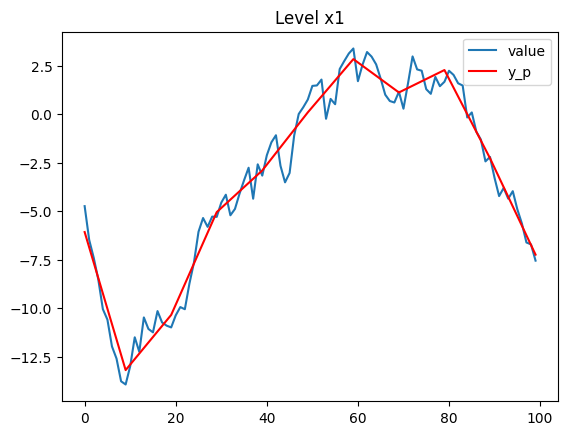

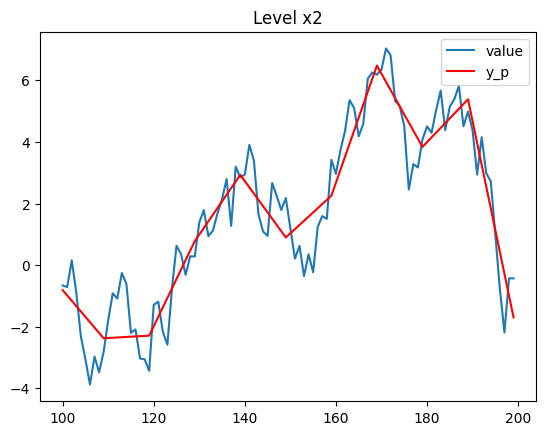

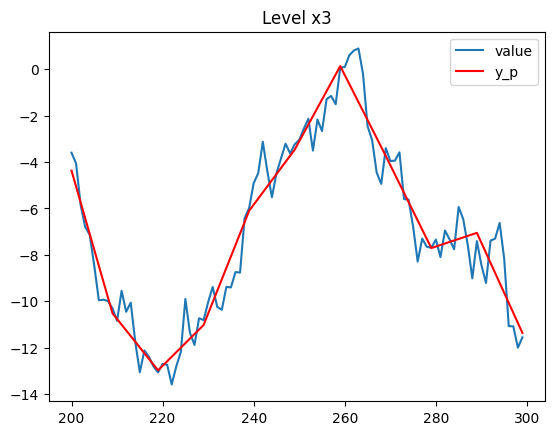

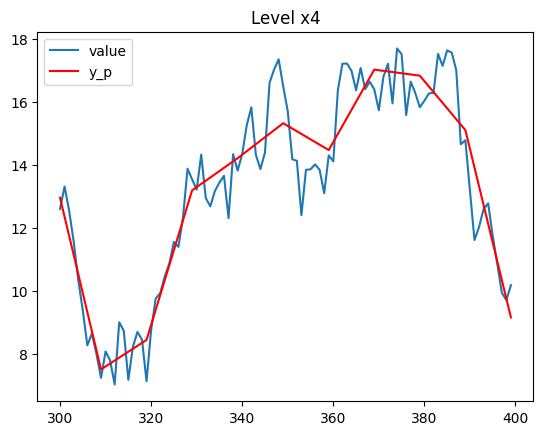

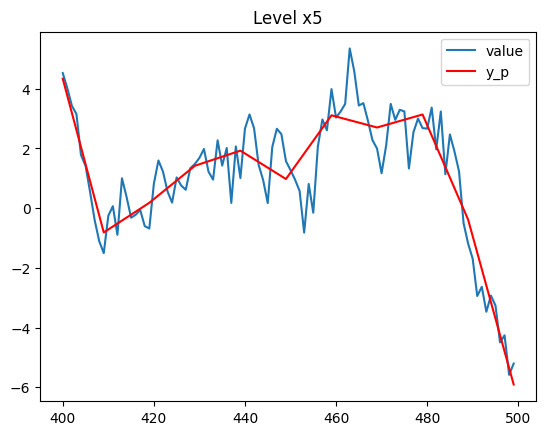

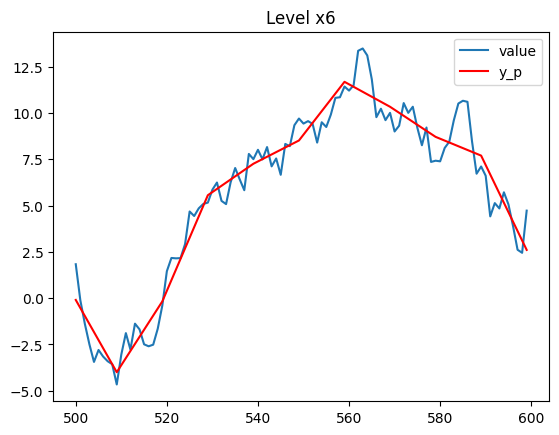

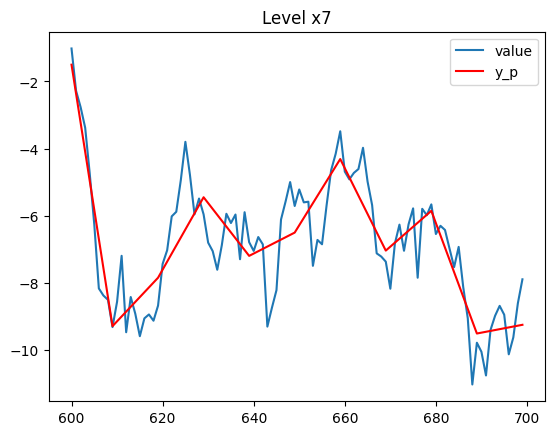

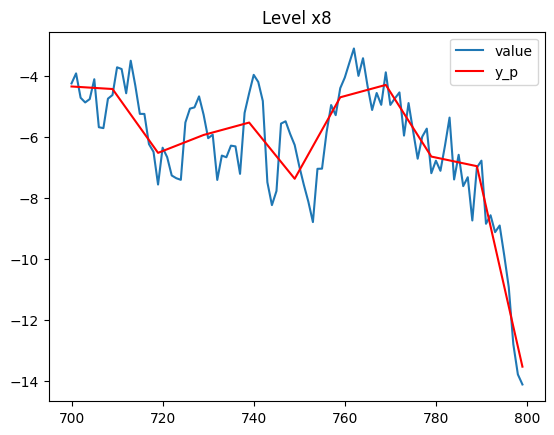

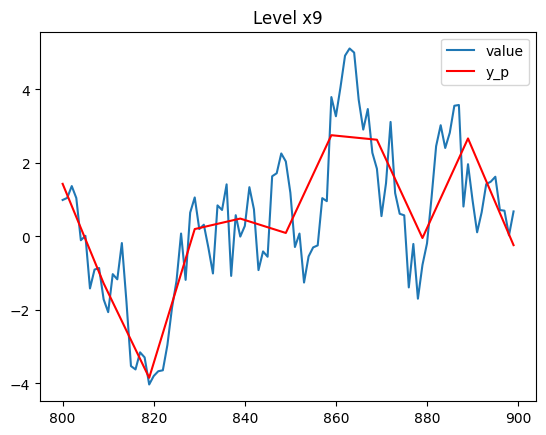

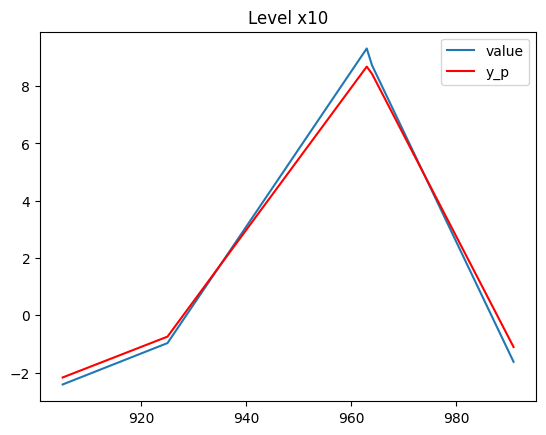

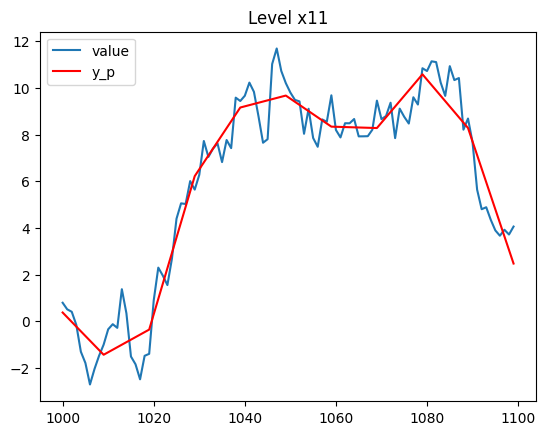

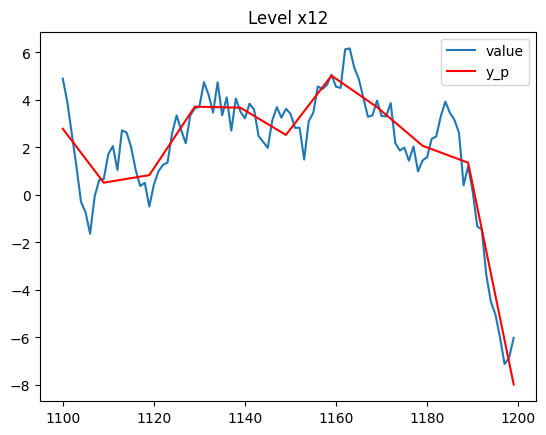

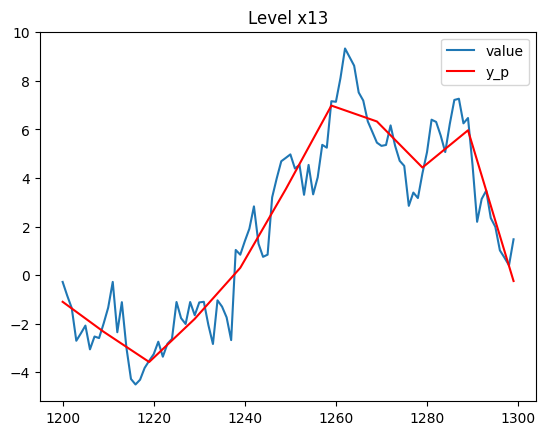

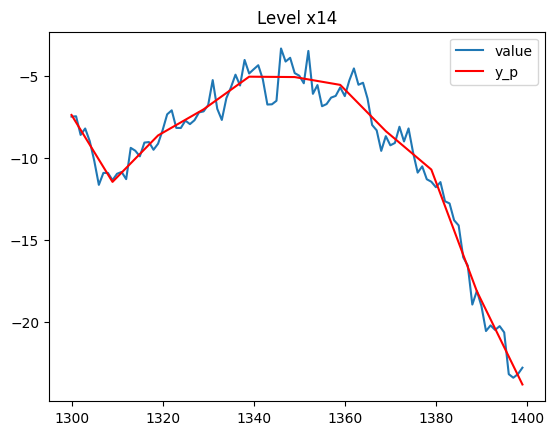

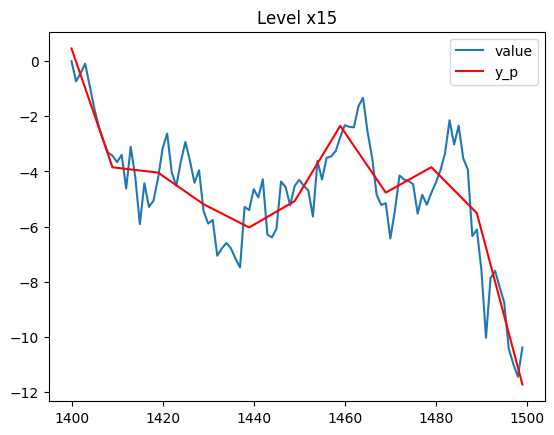

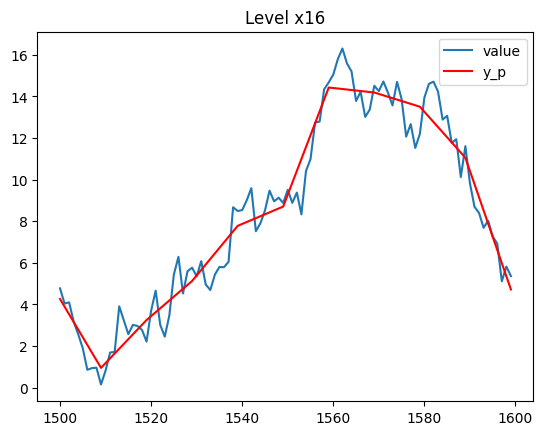

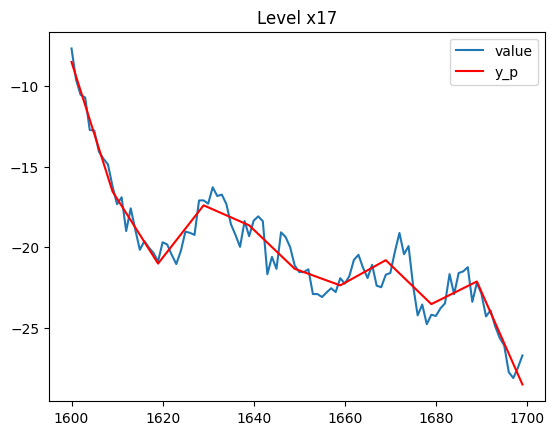

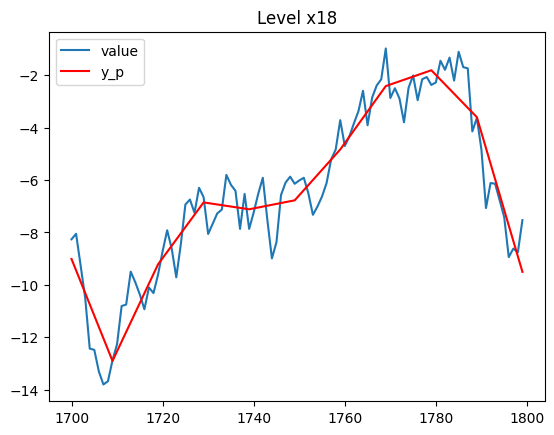

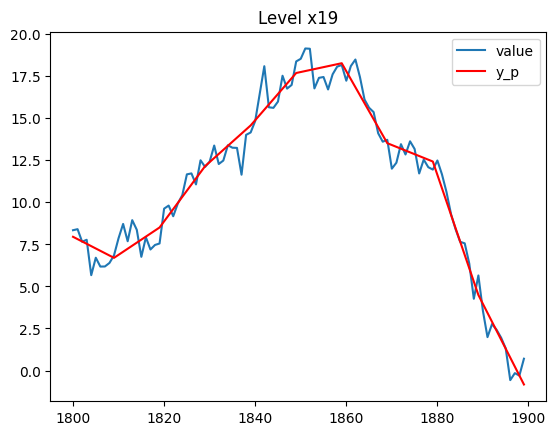

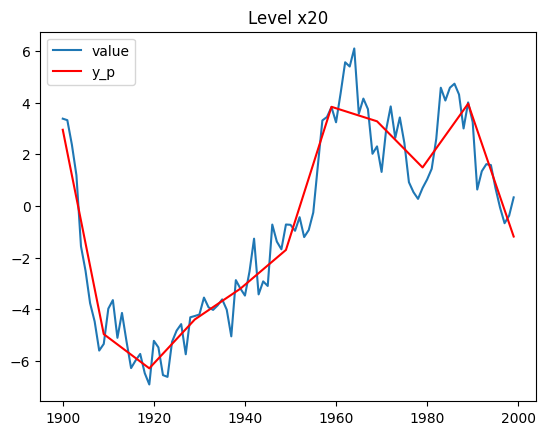

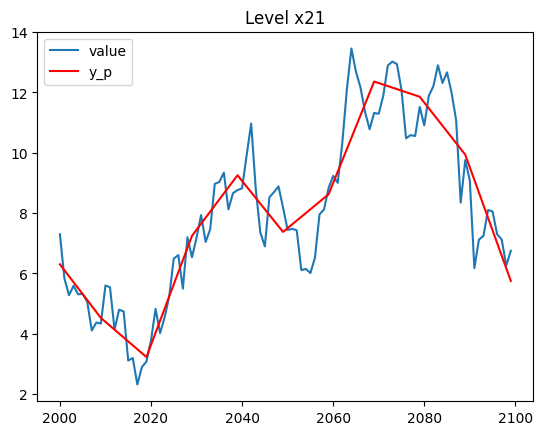

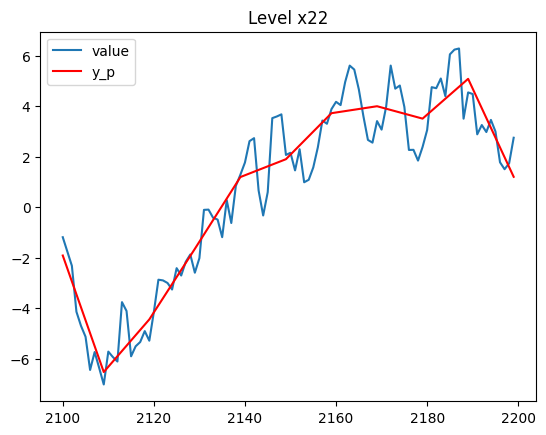

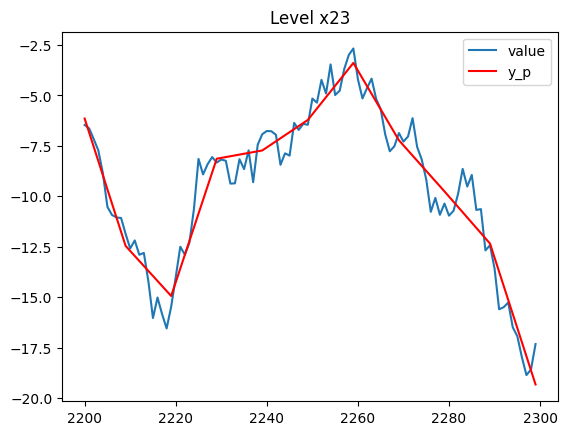

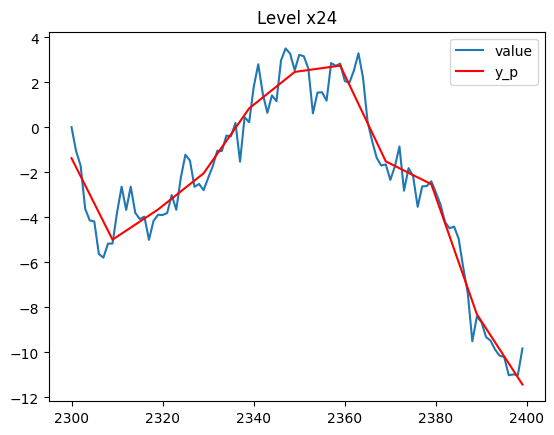

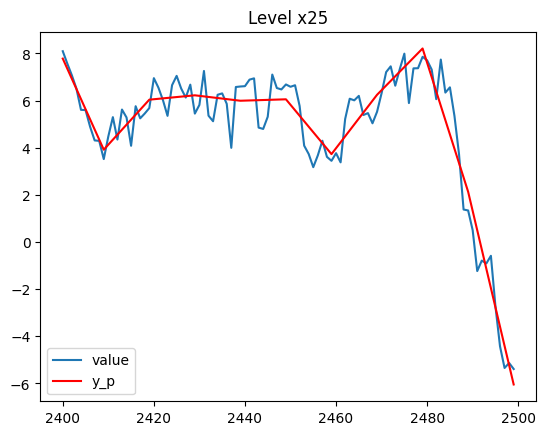

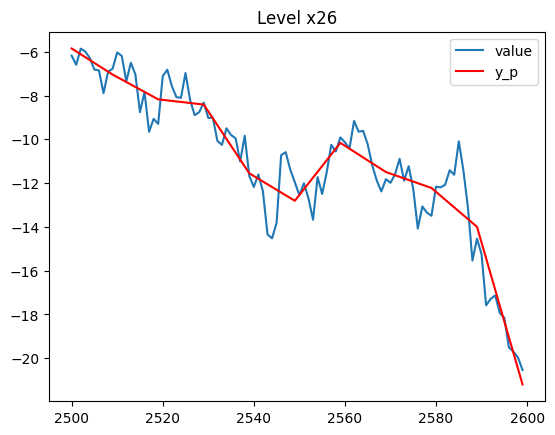

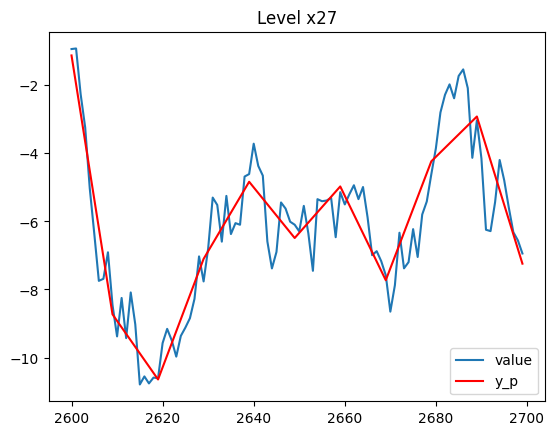

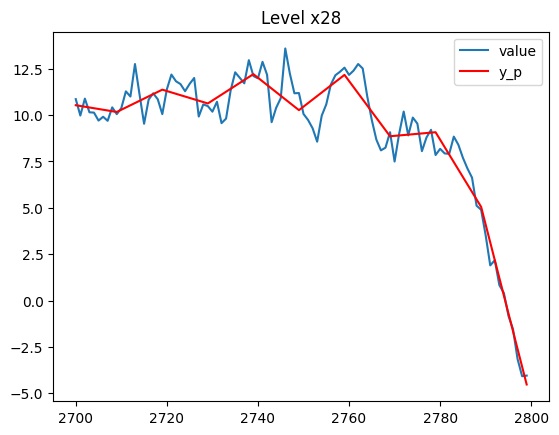

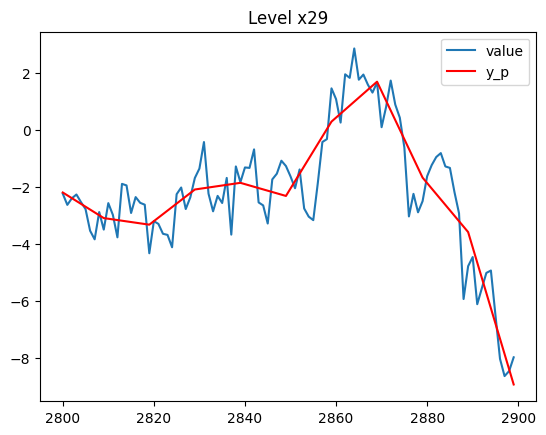

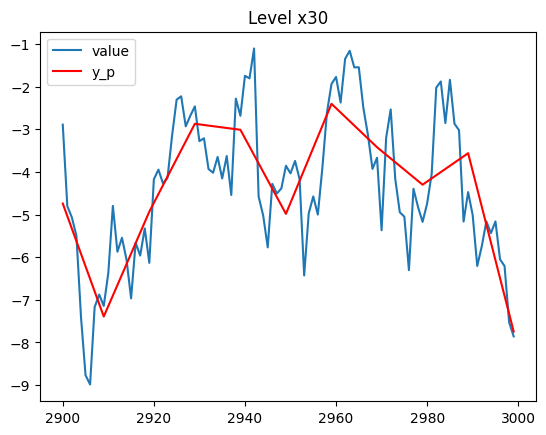

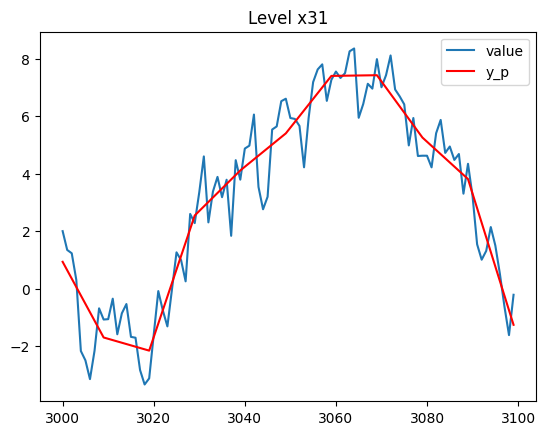

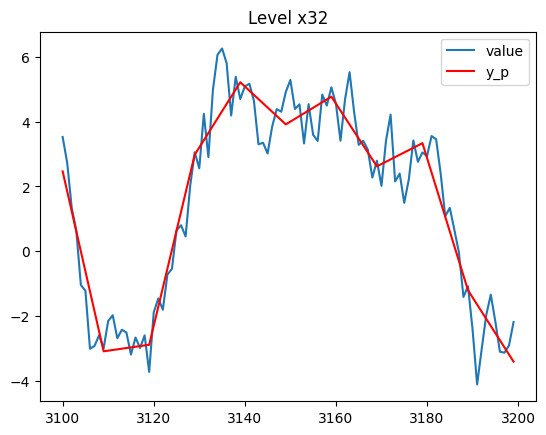

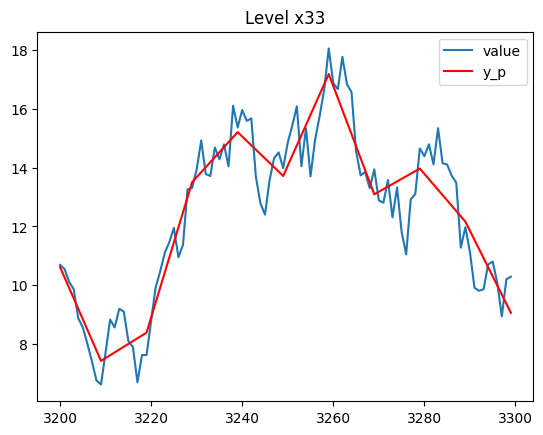

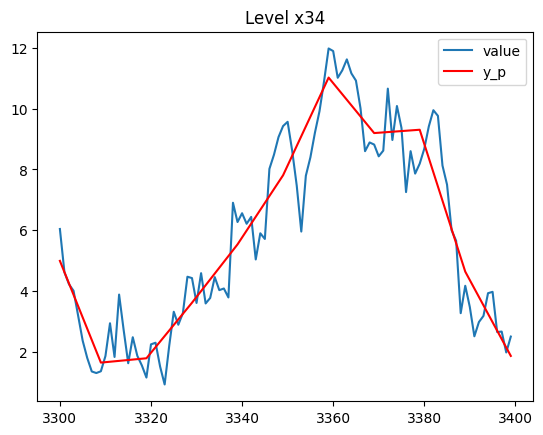

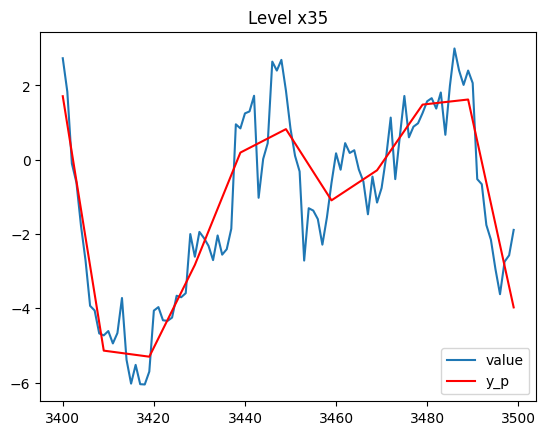

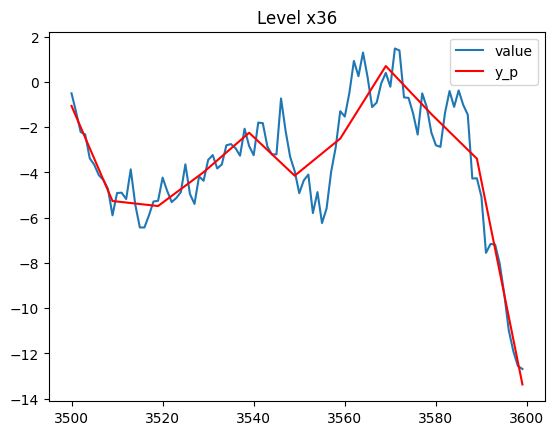

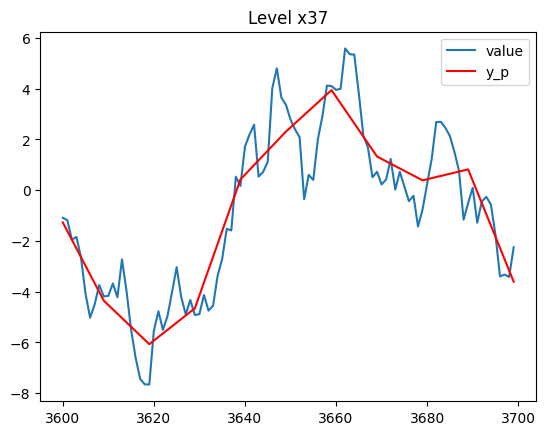

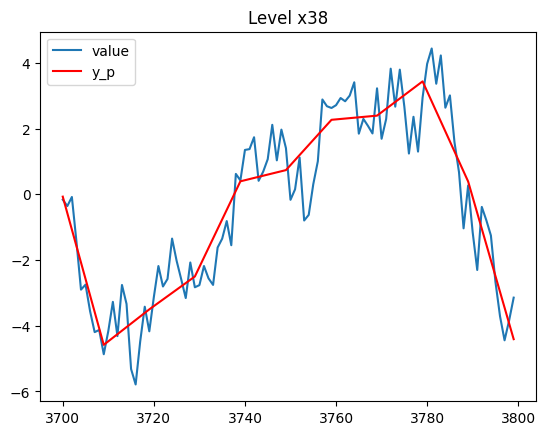

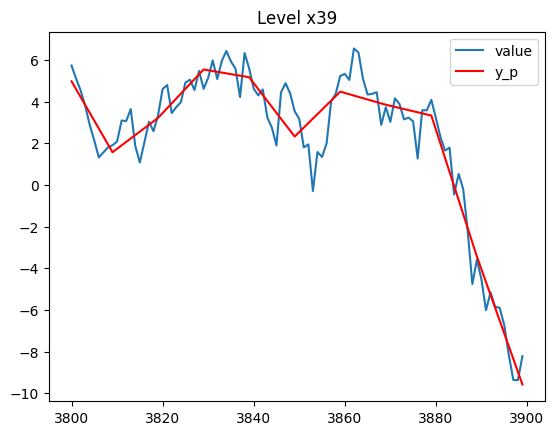

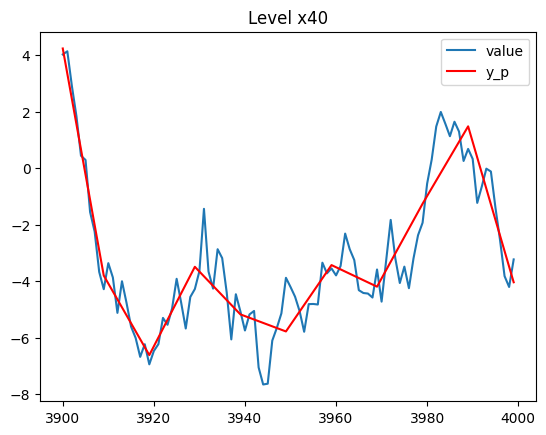

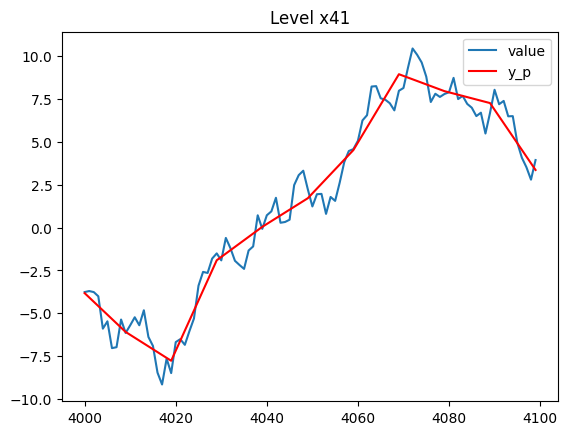

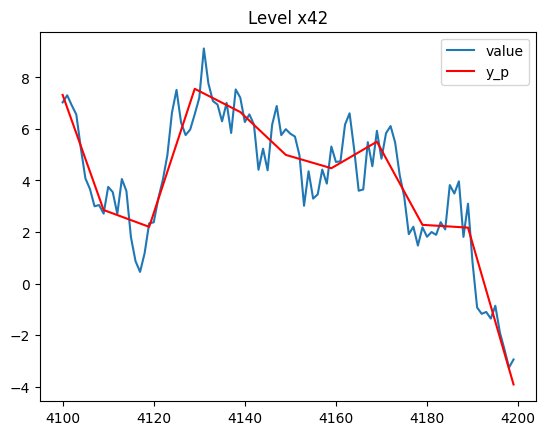

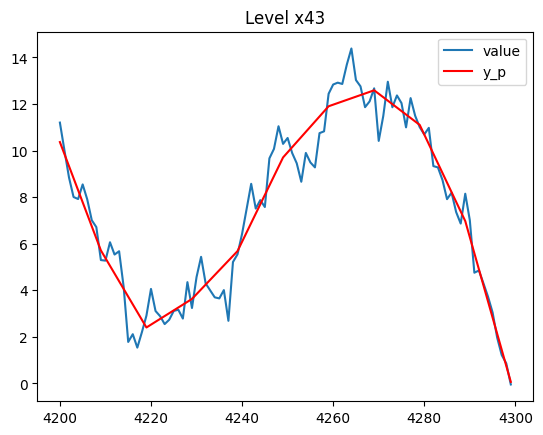

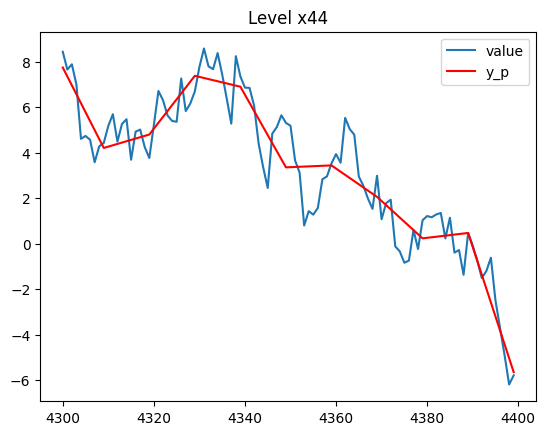

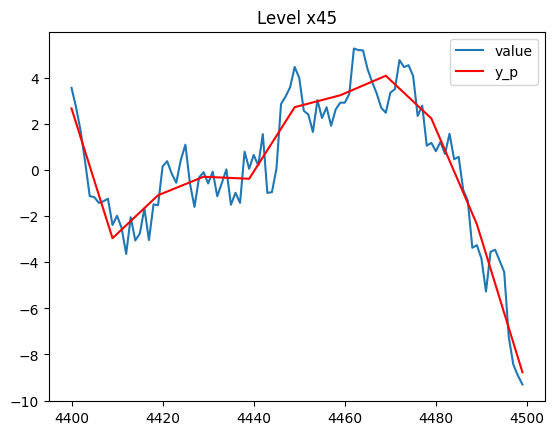

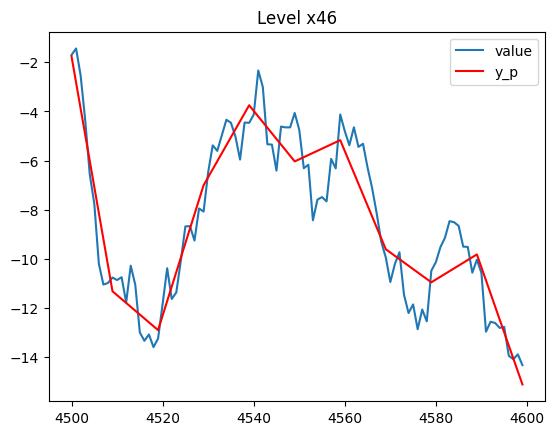

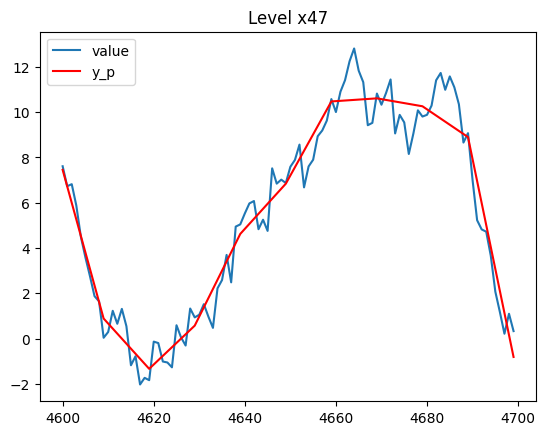

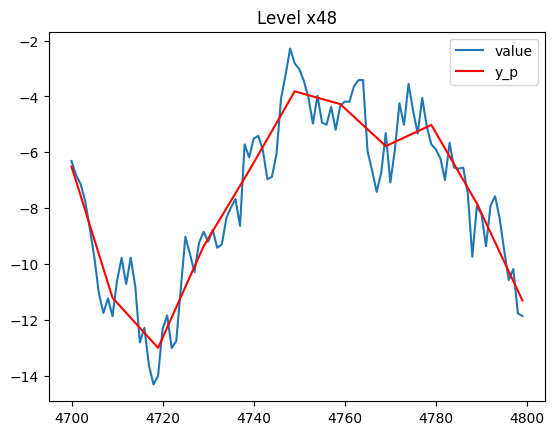

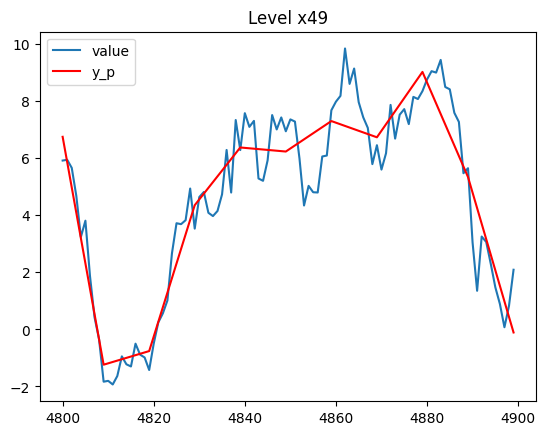

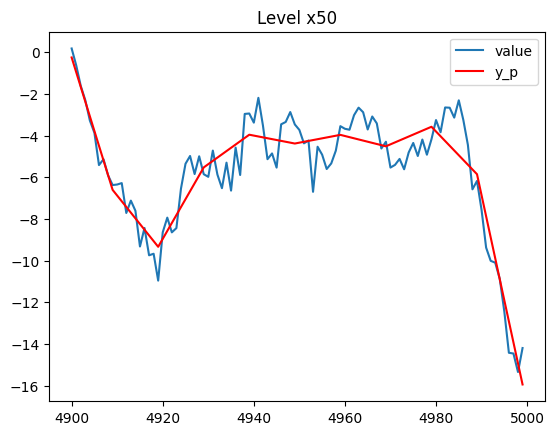

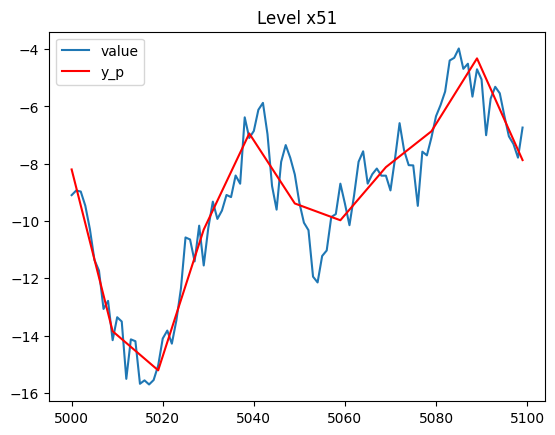

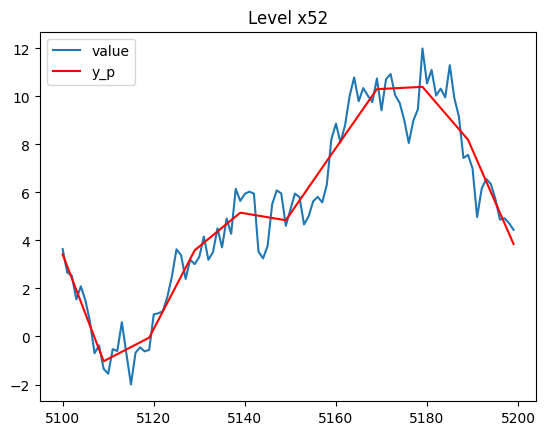

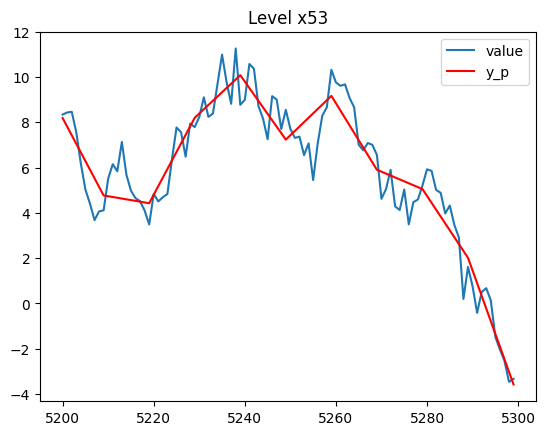

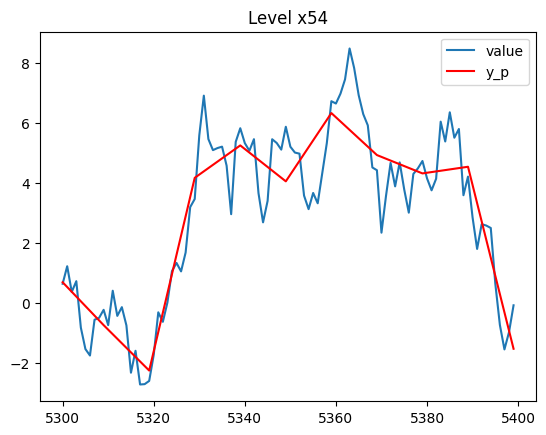

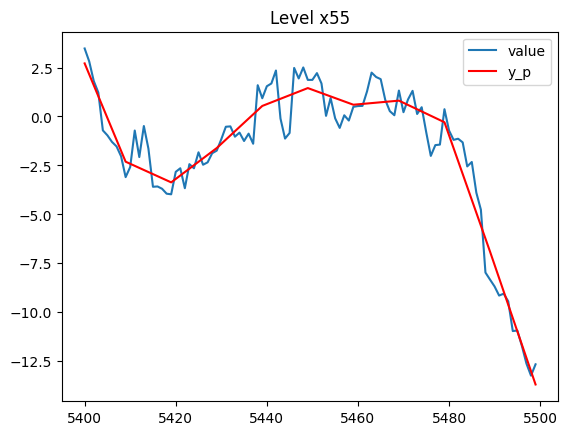

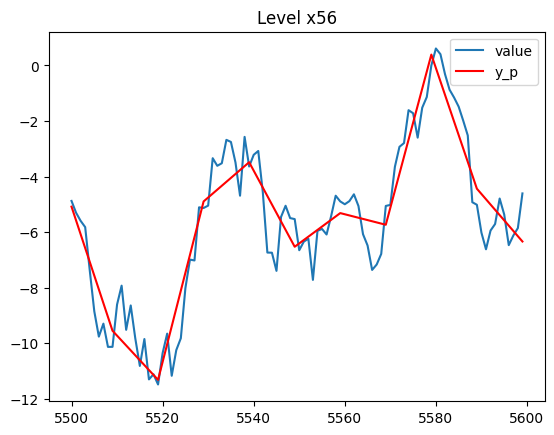

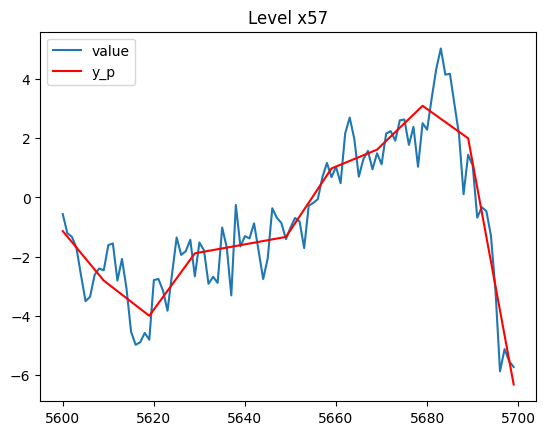

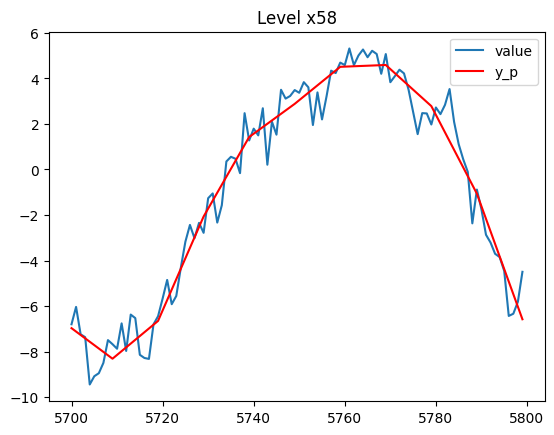

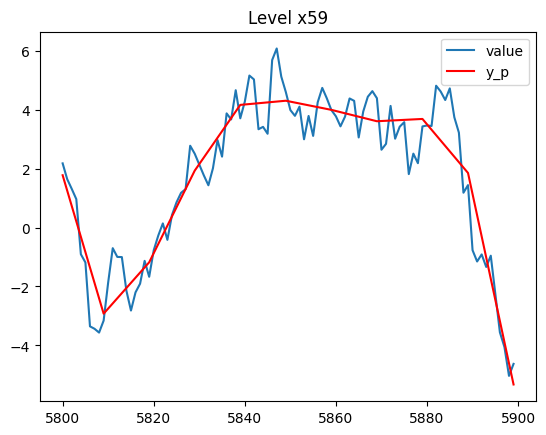

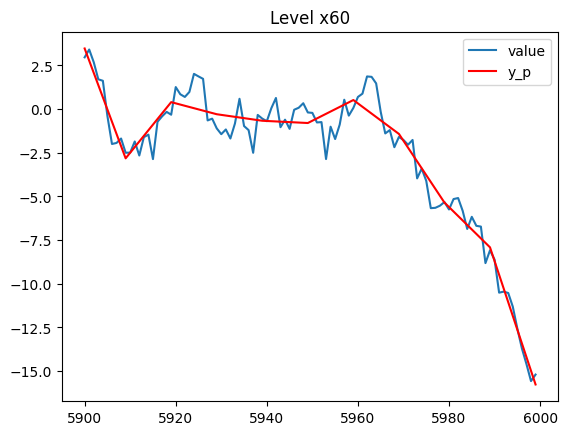

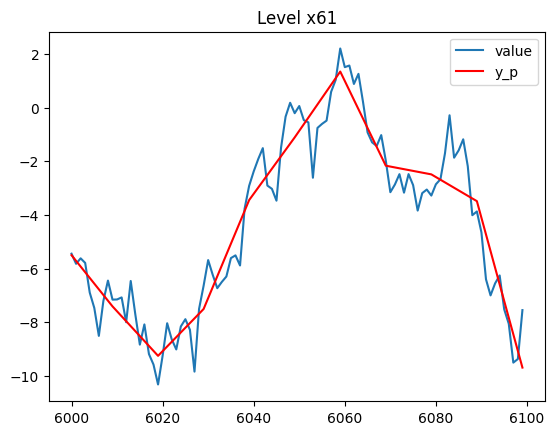

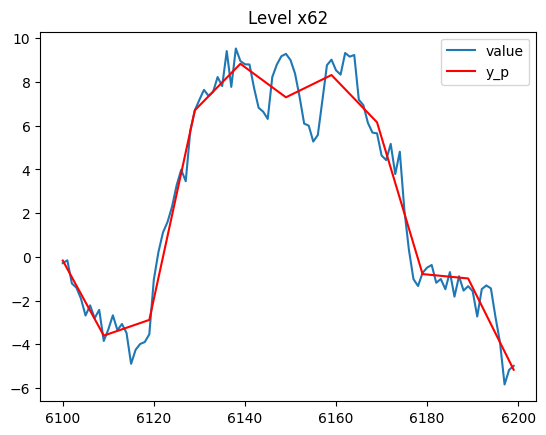

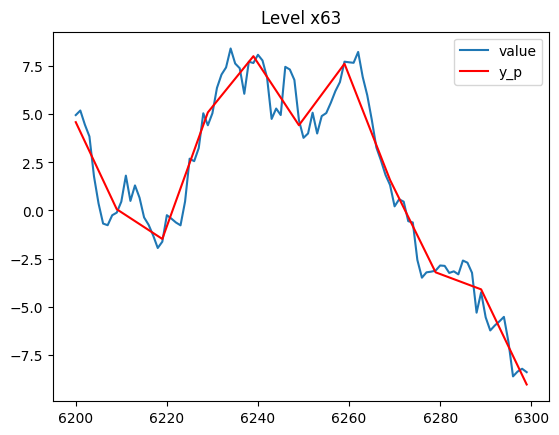

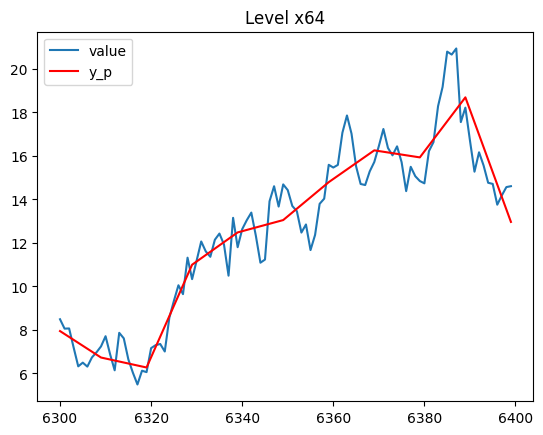

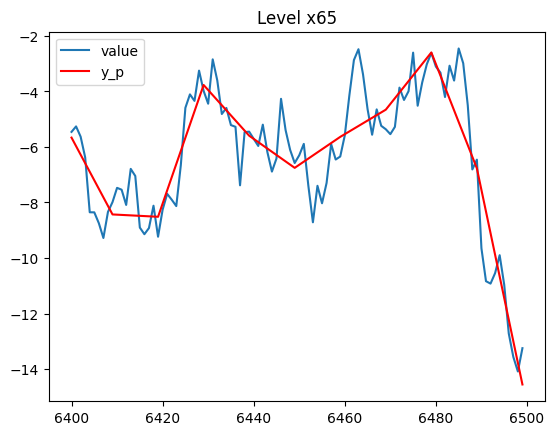

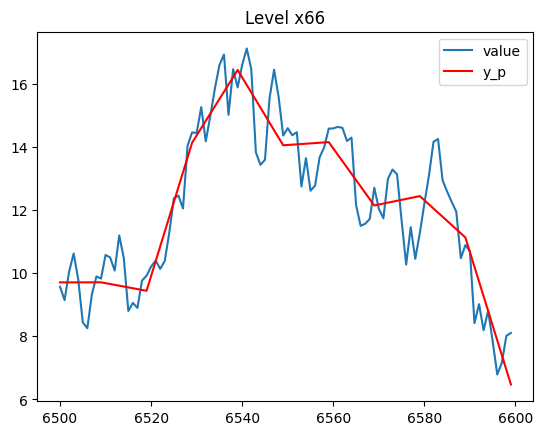

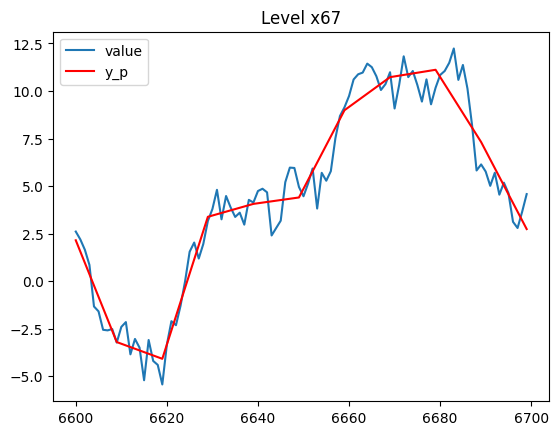

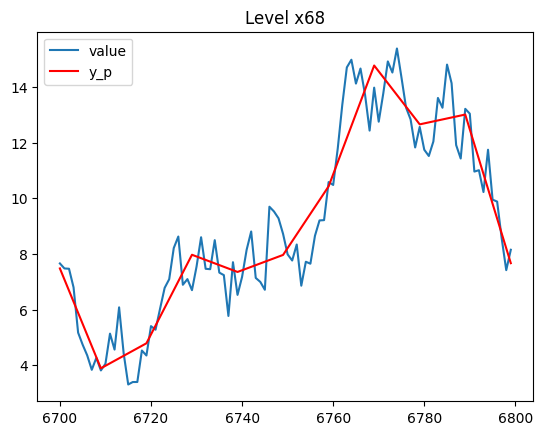

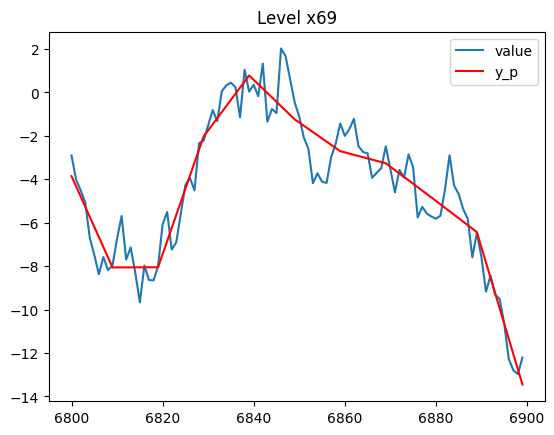

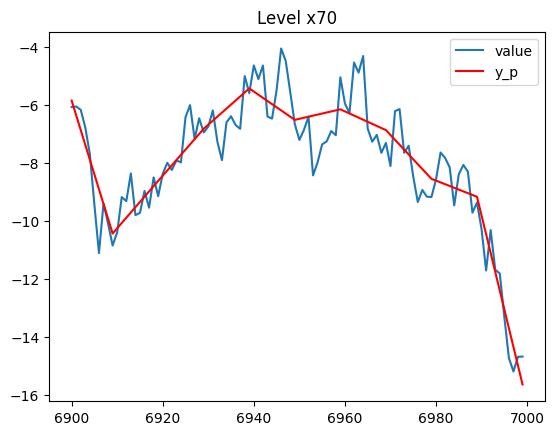

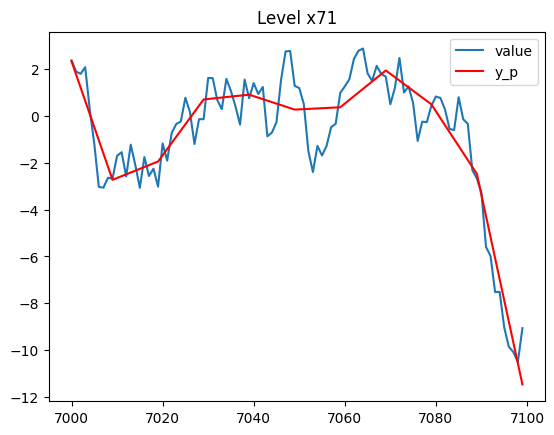

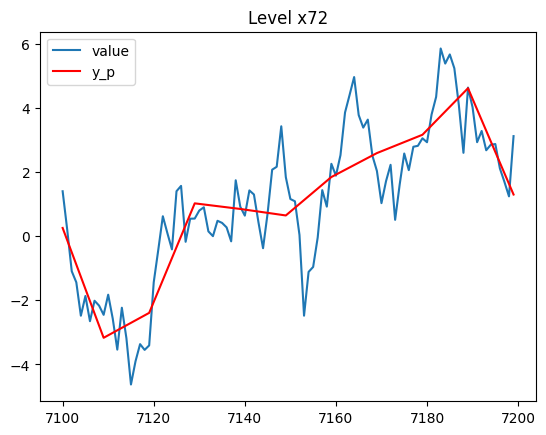

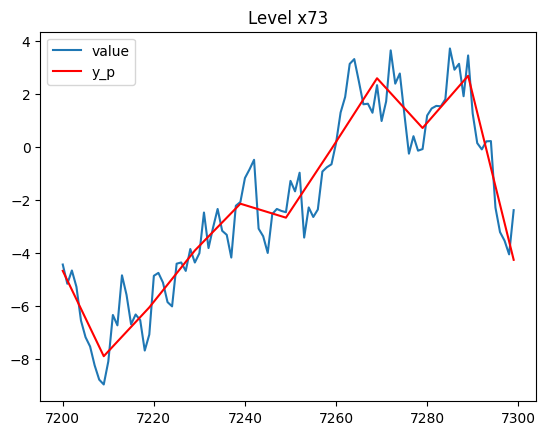

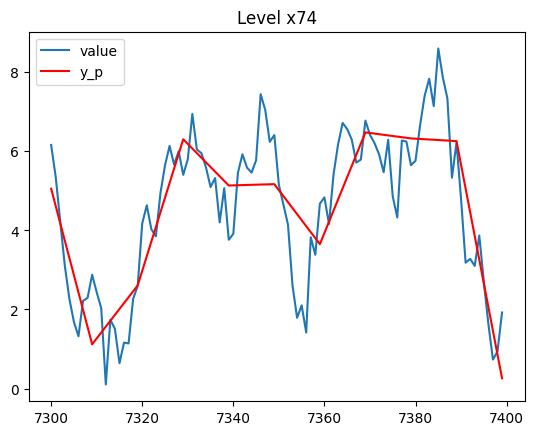

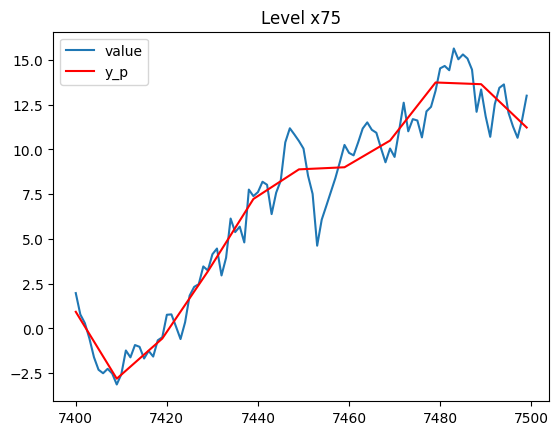

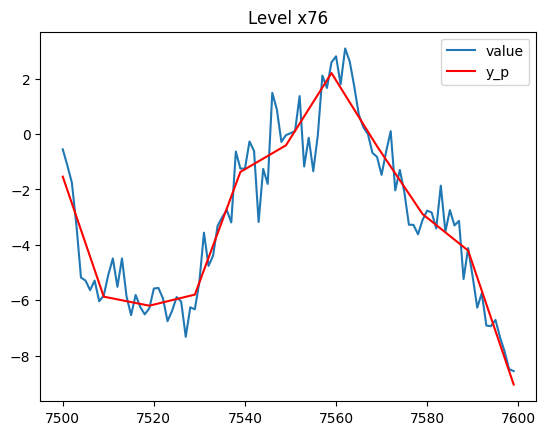

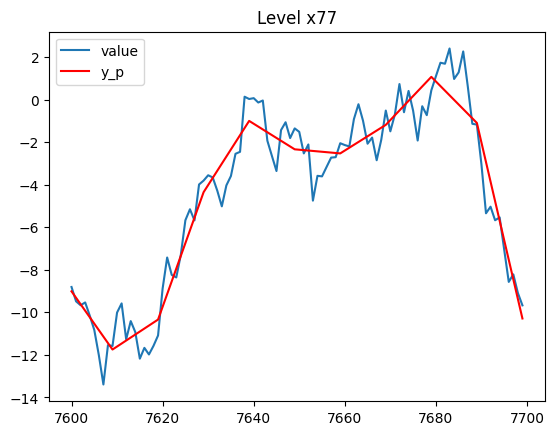

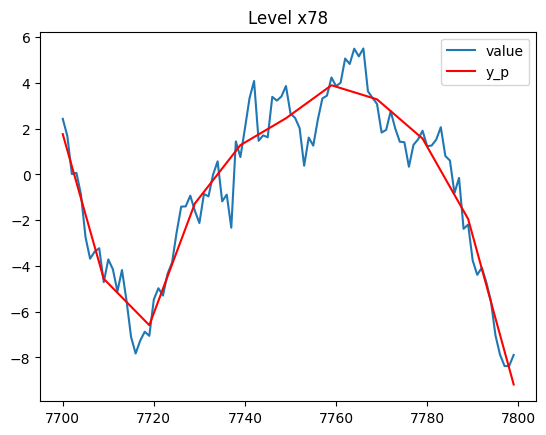

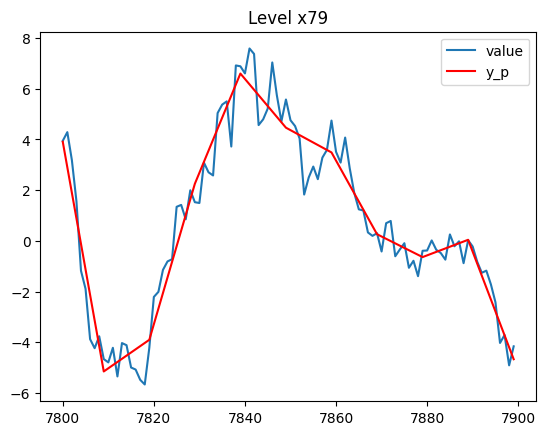

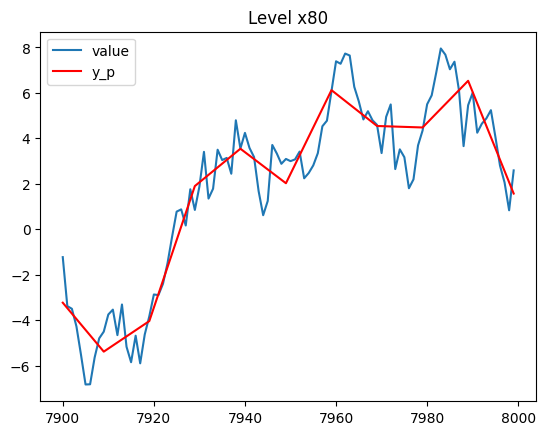

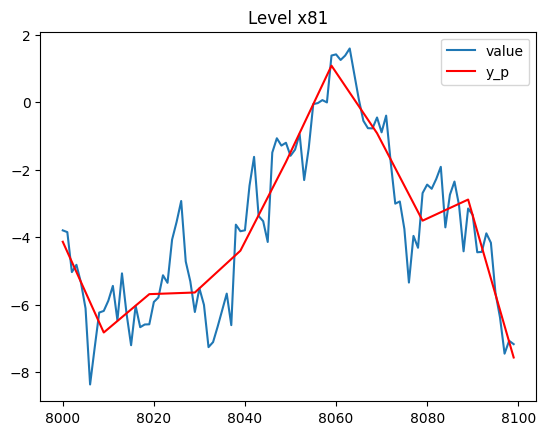

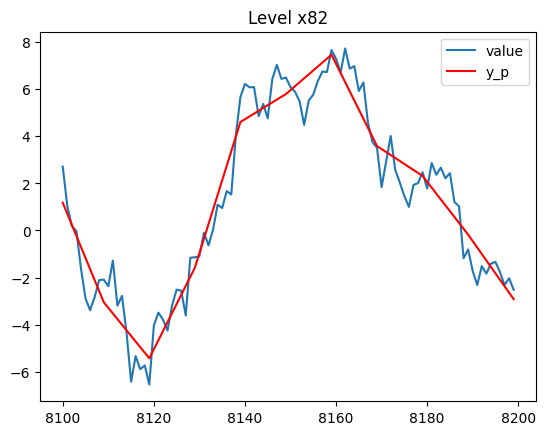

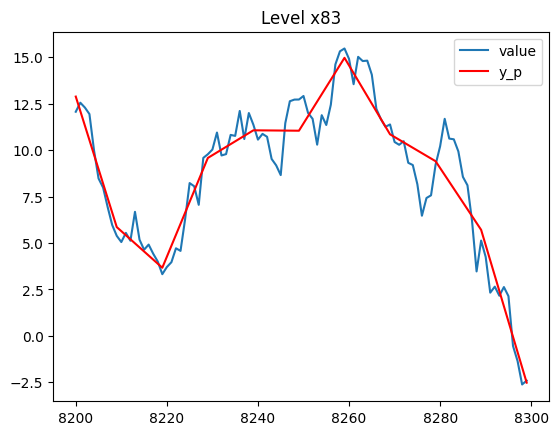

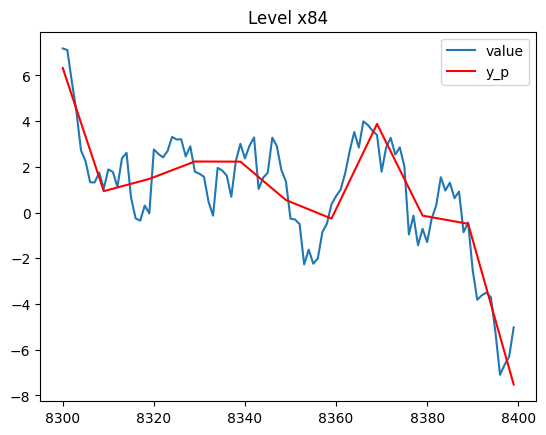

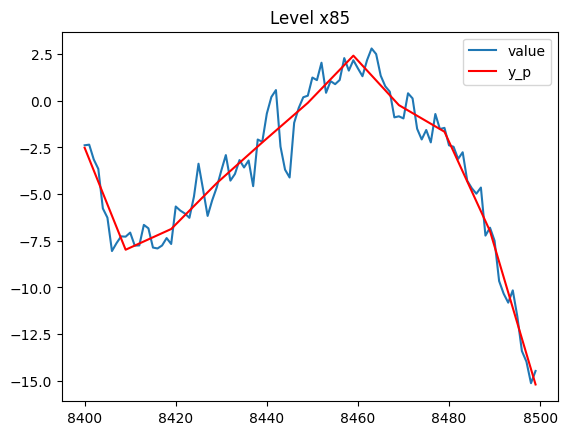

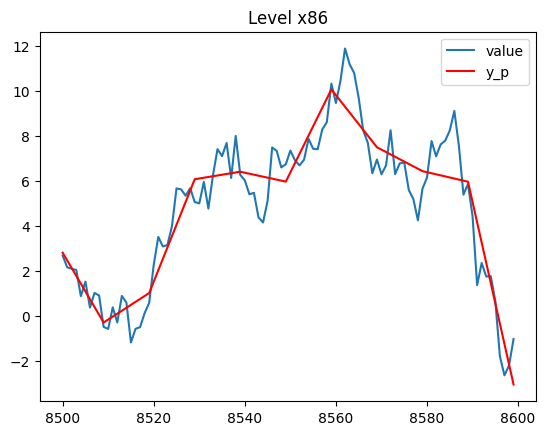

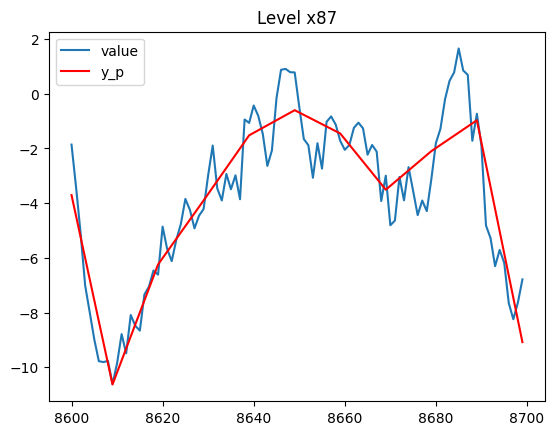

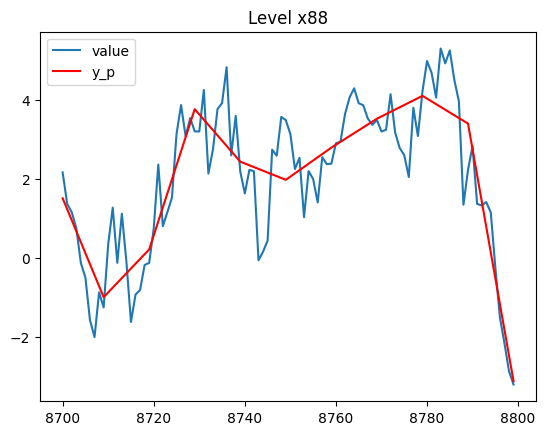

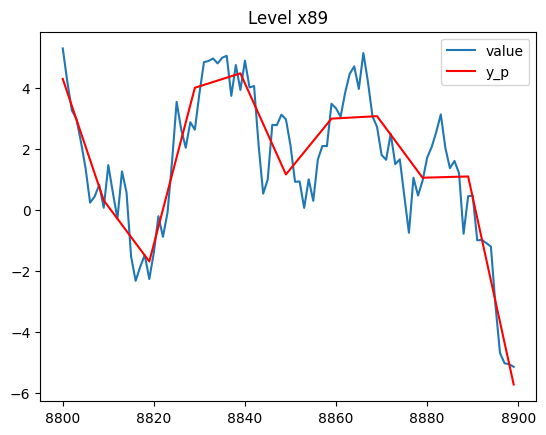

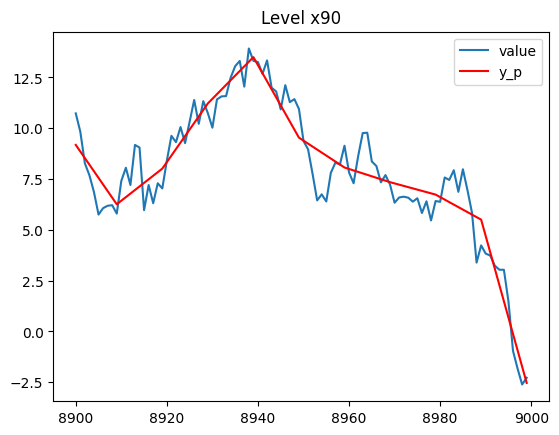

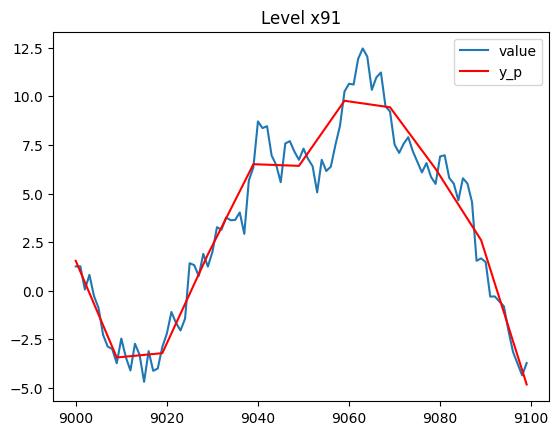

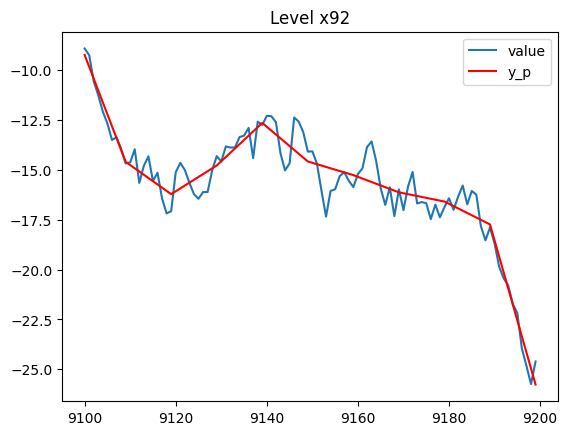

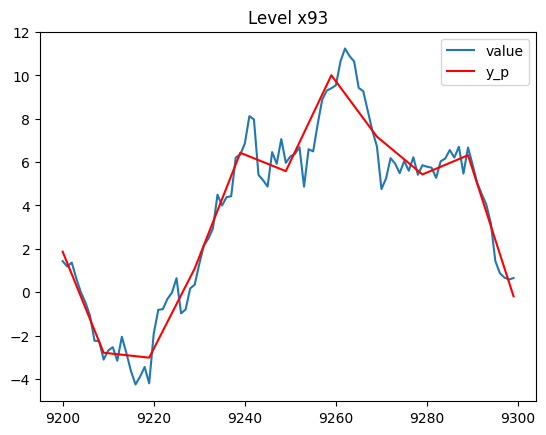

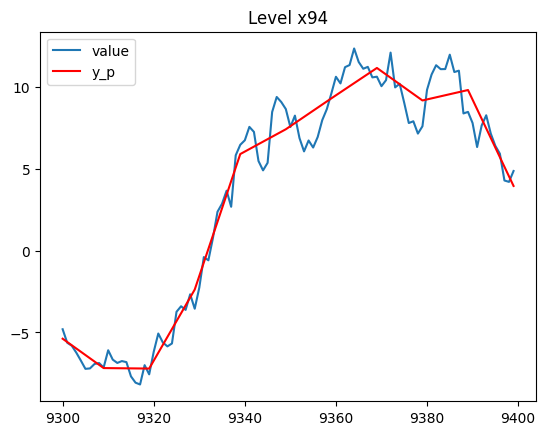

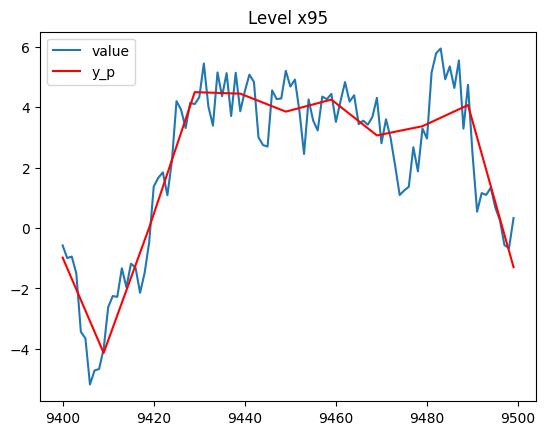

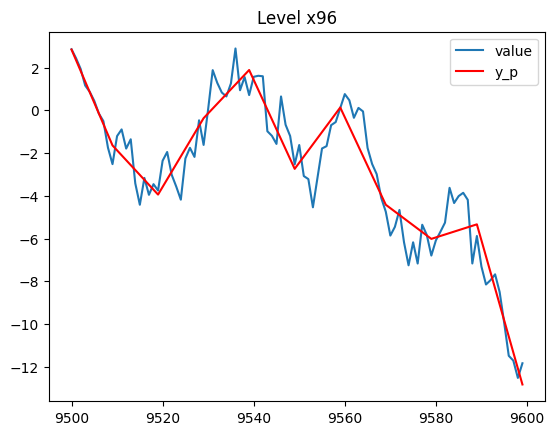

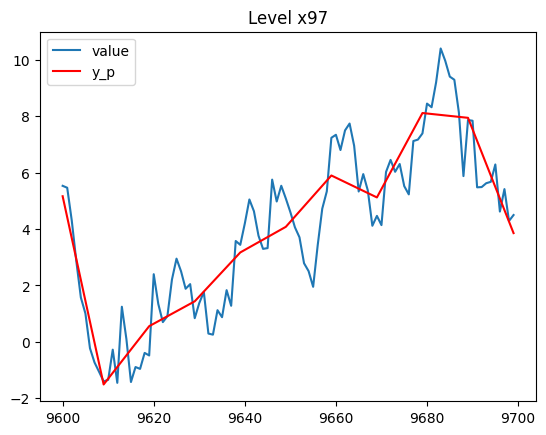

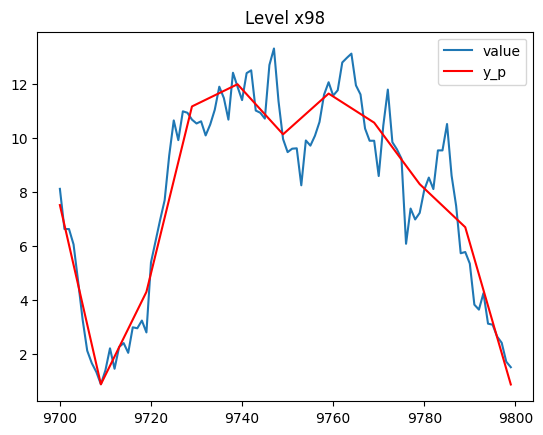

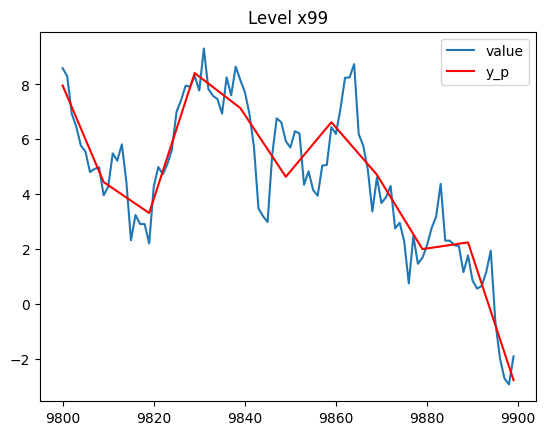

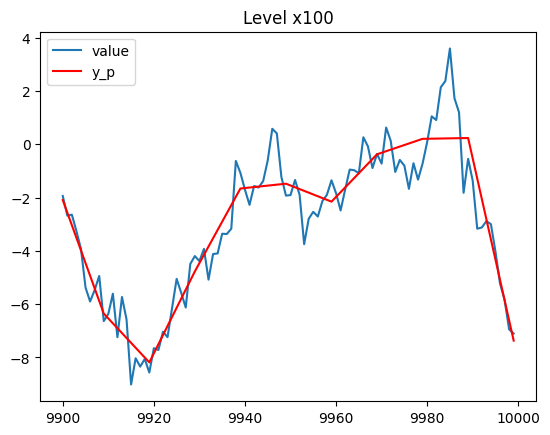

In [25]:
unique_levels = sample_df['level'].unique()

# Loop through unique levels
for level in unique_levels:
    x1 = sample_df[sample_df['level'] == level]

    # Plot the 'value' and 'y_p' columns
    plt.plot(x1['value'], label='value')
    plt.plot(x1['y_p'], color='red', label='y_p')
    plt.legend()
    plt.title(f'Level {level}')
    plt.show()



In [26]:
sample_df[sample_df['level'] == 'x10']

t level     value  basis_X1  basis_X2  basis_X3  basis_X4  basis_X5  \
905   6   x10 -2.416987       6.0       0.0       0.0       0.0       0.0   
925  26   x10 -0.971051      26.0      16.0       6.0       0.0       0.0   
963  64   x10  9.316285      64.0      54.0      44.0      34.0      24.0   
964  65   x10  8.732626      65.0      55.0      45.0      35.0      25.0   
991  92   x10 -1.625046      92.0      82.0      72.0      62.0      52.0   

     basis_X6  basis_X7  basis_X8  basis_X9  basis_X10       y_p  
905       0.0       0.0       0.0       0.0        0.0 -2.172345  
925       0.0       0.0       0.0       0.0        0.0 -0.745725  
963      14.0       4.0       0.0       0.0        0.0  8.682630  
964      15.0       5.0       0.0       0.0        0.0  8.433149  
991      42.0      32.0      22.0      12.0        2.0 -1.107868

In [27]:
basis_vars

array(['basis_X1', 'basis_X2', 'basis_X3', 'basis_X4', 'basis_X5',
       'basis_X6', 'basis_X7', 'basis_X8', 'basis_X9', 'basis_X10'],
      dtype=object)

In [ ]:
pred_df = long_df[basis_vars]
pred_df.insert(0, 'intercept', np.repeat(1, pred_df.shape[0]))

In [29]:
pred_df.head()

intercept  basis_X1  basis_X2  basis_X3  basis_X4  basis_X5  basis_X6  \
0          1       1.0       0.0       0.0       0.0       0.0       0.0   
1          1       2.0       0.0       0.0       0.0       0.0       0.0   
2          1       3.0       0.0       0.0       0.0       0.0       0.0   
3          1       4.0       0.0       0.0       0.0       0.0       0.0   
4          1       5.0       0.0       0.0       0.0       0.0       0.0   

   basis_X7  basis_X8  basis_X9  basis_X10  
0       0.0       0.0       0.0        0.0  
1       0.0       0.0       0.0        0.0  
2       0.0       0.0       0.0        0.0  
3       0.0       0.0       0.0        0.0  
4       0.0       0.0       0.0        0.0

In [30]:

re = model.predict(result.random_effects["x10"], exog=pred_df)
fe = model.predict(result.fe_params, exog=pred_df)



In [31]:
y_p = re + fe


In [32]:
result.random_effects["x10"]

Group       -1.101541
basis_X1     0.050236
basis_X2     0.001108
basis_X3     0.011782
basis_X4     0.146877
basis_X5     0.003067
basis_X6    -0.054584
basis_X7    -0.347045
basis_X8    -0.012861
basis_X9    -0.092571
basis_X10    0.293039
dtype: float64

In [33]:
result.fe_params

Intercept    1.420749
basis_X1    -0.465495
basis_X2     0.478808
basis_X3     0.330409
basis_X4    -0.179082
basis_X5    -0.184212
basis_X6     0.172836
basis_X7    -0.214185
basis_X8    -0.009345
basis_X9    -0.076100
basis_X10   -0.439265
dtype: float64

In [34]:
long_df['y_p'] = y_p

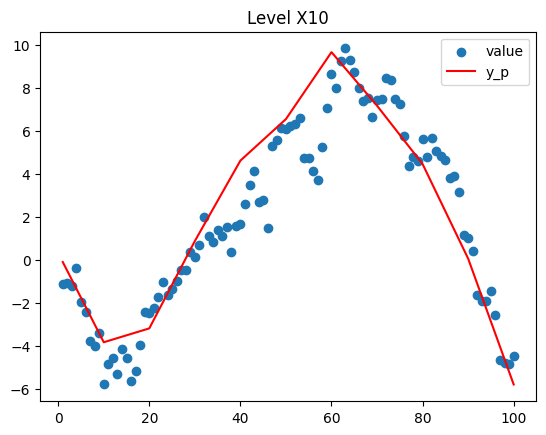

In [35]:
x1 = long_df[long_df['level'] == "x10"]
# Plot the 'value' and 'y_p' columns
plt.scatter(x1['t'],x1['value'], label='value')
plt.plot(x1['t'],x1['y_p'], color='red', label='y_p')
plt.legend()
plt.title(f'Level X10')
plt.show()

###Pytorch Formulation

In [108]:
y = torch.tensor(np.array(sample_df['value']))
y = y/torch.max(y)
y = y

In [110]:
level = pd.get_dummies(sample_df['level'])
cols = [f"x{int(i)}" for i in range(1,100)]
level = level[cols]
L = torch.tensor(np.array(level).astype('float32'))
L = L

In [150]:
# Example data
# Create a matrix containing all basis functions as columns
pred_df = sample_df[basis_vars]
X = torch.tensor(np.array(pred_df.iloc[:,1:pred_df.shape[0]]).astype('float32'))
X = X/100
X = X

**Define the mixed effect model in pytorch**

In [137]:
class MixedEffectNetwork(nn.Module):
    def __init__(self, n_level, n_basis):
        super().__init__()

        self.n_basis = n_basis
        self.n_level = n_level
        # Linear Layers
        self.F = nn.Parameter(torch.rand(n_basis))

        # Overall intercept
        self.intercept = nn.Parameter(torch.rand(1))

        # Intercept random effect
        self.R_int = nn.Parameter(torch.rand(n_level))

        # Basis slope random effects
        self.R_effect = nn.Parameter(torch.rand(n_level, n_basis))

        # Additional parameter layers
        self.sd1 = nn.Parameter(torch.tensor(1.0)) # Error

        # Random effect regularisation
        self.u2 = nn.Parameter(torch.ones(n_level, n_basis))
        self.sd2 = nn.Parameter(torch.ones(n_level, n_basis))

        # Intercept random effect regularisation
        self.u3 = nn.Parameter(torch.ones(n_level))
        self.sd3 = nn.Parameter(torch.ones(n_level))


    def forward(self, X, L):

        # Fixed effects
        xf = torch.matmul(X, self.F)

        # Random effect intercept
        lr = torch.matmul(L, self.R_int.unsqueeze(1))

        # Random effect slopes
        lr_slope = torch.matmul(L, self.R_effect)
        X = X[:,:,None]
        lr_slope = lr_slope[:, None, :]
        lrx = torch.matmul(lr_slope, X)

        # Sum them all together
        y_p = lrx.squeeze(1).squeeze(1) + self.intercept + lr.squeeze(1)  + xf

        return y_p

    def loss(self, y_p, y):

        # Get the log likelihood for each of the random effect parameters
        l2 = 0
        for i in range(self.n_level):
          for j in range(self.n_basis):
            l2_dist = dist.Normal(self.u2[i,j], torch.exp(self.sd2[i,j]))
            l2 =+ l2_dist.log_prob(self.R_effect[i,j] - self.u2[i,j])

        l3 = 0
        for i in range(self.n_level):
          l3_dist = dist.Normal(self.u3[i], torch.exp(self.sd3[i]))
          l3 =+ l3_dist.log_prob(self.R_int[i] - self.u3[i])

        # Get the log likelihood for the error
        l1_dist = dist.Normal(0, torch.exp(self.sd1))
        l1 = l1_dist.log_prob(y - y_p).sum()

        # Sum them together and then scale them via the mean
        l = (l1 + l2 + l3) / ((self.u2.shape[0]*self.u2.shape[1]) + y.shape[0] + self.u3.shape[0])

        return -(l)


**Train the model on the sample data**

In [141]:
# Create an instance of the network
model = MixedEffectNetwork(n_level=99, n_basis=10)

# Define the optimizer (SGD)
optimizer = optim.RMSprop(model.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

num_epochs = 5000

history = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_p = model(X, L)
    loss = model.loss(y_p, y)
    history.append(loss.detach().numpy())
    loss.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 100 == 0:
      print(f"LR:{optimizer.param_groups[0]['lr']}")
      print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss}')



LR:0.0999
Epoch [1/5000], Loss: 2.3757539985518448
LR:0.09038873549665954
Epoch [101/5000], Loss: 0.3776621776436898
LR:0.08178301806491572
Epoch [201/5000], Loss: 1.3345140713305337
LR:0.07399663251239438
Epoch [301/5000], Loss: 0.24821430978159742
LR:0.0669515720100734
Epoch [401/5000], Loss: -0.041649448402588295
LR:0.060577256591632454
Epoch [501/5000], Loss: -0.27636646894856204
LR:0.05480982605780123
Epoch [601/5000], Loss: -0.49971771070084353
LR:0.049591500201766864
Epoch [701/5000], Loss: -0.6633823007033877
LR:0.04486999994614655
Epoch [801/5000], Loss: -0.7789053769415505
LR:0.04059802359226594
Epoch [901/5000], Loss: -0.4969170286684662
LR:0.03673277293461932
Epoch [1001/5000], Loss: -0.6421306406060077
LR:0.03323552449295458
Epoch [1101/5000], Loss: -0.7290017799085152
LR:0.030071241566430654
Epoch [1201/5000], Loss: -0.8370541836558391
LR:0.027208223223265812
Epoch [1301/5000], Loss: -0.9487481281424075
LR:0.02461778670932776
Epoch [1401/5000], Loss: -1.046491935522339
LR

Plot some random effects distributions

(array([ 5.,  7.,  5., 13., 18., 19., 16.,  8.,  3.,  5.]),
 array([-1.83756769, -1.55826378, -1.27895987, -0.9996559 , -0.72035193,
        -0.44104803, -0.16174409,  0.11755984,  0.39686376,  0.67616773,
         0.95547163]),
 <BarContainer object of 10 artists>)

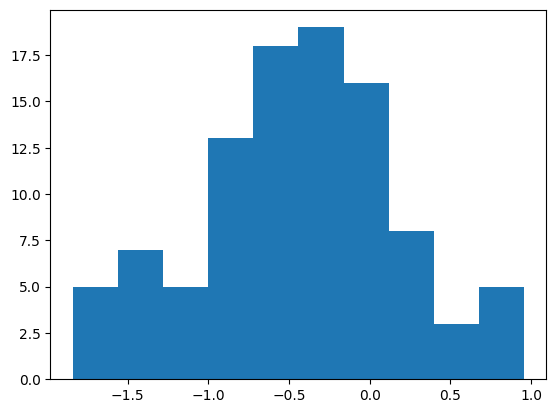

In [149]:
plt.hist(model.R_effect.detach().numpy()[:,4])

**Reconstruction**
Predict the values on the complete data frame and reconstruct X10


In [153]:
level = pd.get_dummies(long_df['level'])
cols = [f"x{int(i)}" for i in range(1,100)]
level = level[cols]
L = torch.tensor(np.array(level).astype('float32'))
L = L

# Example data
# Create a matrix containing all basis functions as columns
pred_df = long_df[basis_vars]
X = torch.tensor(np.array(pred_df.iloc[:,:pred_df.shape[0]]).astype('float32'))
X = X/100
X = X

In [154]:
y_reconstruct = model(X, L)

**Plot the reconstruction**

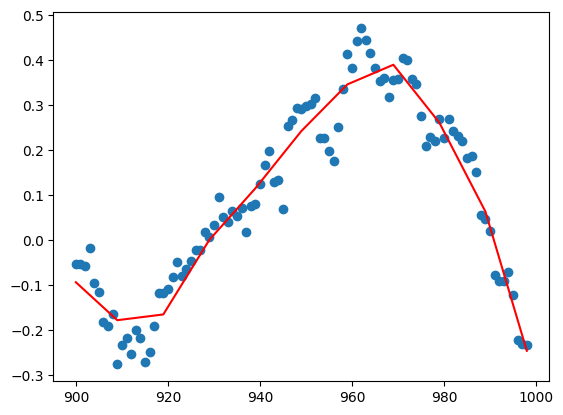

In [162]:
plt.plot(range(900,999), y_p.detach().numpy()[900:999], color="red")
plt.scatter(range(900,999),y[900:999])
plt.show()